<a href="https://colab.research.google.com/github/ij264/Corpus-Drawing-Project/blob/master/sketchRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ipython-autotime

%load_ext autotime

# imports
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import random

# hyperparameters
# UPDATE

hp = {
    'location': '/content/drive/Shared drives/Corpus Drawing Project/data/sketchrnn_airplane.npz',
    'Nz': 128,
    'batch_size': 25,
    'encoder_hidden_size': 256,
    'decoder_hidden_size': 512,
    'temperature': 0.1,
    'gradient_clipping': 1.0,
    'lr': 1e-3,
    'min_lr' : 1e-5,
    'decay_rate': 0.99999,
    'KL_min': 0.2,
    'eta_min': 1e-2,
    'R': 0.99995,
    'M': 20,
    'wKL': 0.5,
    'dropout': 0.1
}

# returns maximum sequence length in stroke sequences in data
def get_max_length(data):
    sequences = [len(seq) for seq in data]
    return max(sequences)

class DataLoader(object):
    def __init__(self,
                 strokes,
                 batch_size=hp['batch_size'],
                 random_scale_factor=0.0,
                 augment_stroke_prob=0.0,
                 limit=1000):
        self.batch_size = batch_size # Batch size.
        self.max_seq_length = get_max_length(strokes) # Nmax.
        self.random_scale_factor = random_scale_factor # Data augmentation method.

        # Removes large gaps in data. x and y offets are clamped to have absolute values no greater than this limit.
        self.limit = limit
        self.augment_stroke_prob = augment_stroke_prob

        # sets self.strokes: list of arrays (sorted by size), one per sketch, in stroke-3 format (DeltaX, DeltaY, pen binary state)
        self.preprocess(strokes)
        self.pad_data(self.strokes, self.max_seq_length)
        self.normalise()
    
    def preprocess(self, strokes): 
        # Removes entries from strokes having a sequence longer than max_seq_lengths
        raw_data = []
        seq_len = []
        count_data = 0
        
        for data in strokes:

            if len(data) <= (self.max_seq_length):
                count_data += 1
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                raw_data.append(data)
                seq_len.append(len(data))

        seq_len = np.array(seq_len)  
        idx = np.argsort(seq_len)

        self.strokes = []

        for i in range(len(seq_len)):
            self.strokes.append(raw_data[idx[i]])

        print("total images <= max_seq_len is %d" % count_data)

        self.num_batches = int(count_data / self.batch_size)
        return self.strokes

    def calculate_normalizing_scale_factor(self):
        ''' Calculate the normalizing factor explained in appendix of sketch-rnn '''
        return torch.std(self.strokes) 

    def normalise(self):
        ''' Normalise entire dataset by normalising factor '''
        scale_factor = self.calculate_normalizing_scale_factor()
        self.strokes[:,:,0:2] /= scale_factor
        return self.strokes

    def pad_data(self, data, max_len):
        ''' Pad the batch to be stroke-5 bigger format as described in paper '''
        padded_data = np.zeros((len(data), max_len, 5), dtype=float)

        for i in range(len(data)):
            l = len(data[i])
            assert l <= max_len
            padded_data[i, 0:l, 0:2] = data[i][:, 0:2]
            padded_data[i, 0:l, 3] = data[i][:, 2]
            padded_data[i, 0:l, 2] = 1 - padded_data[i, 0:l, 3]
            padded_data[i, l:, 4] = 1
            padded_data[i, 1:, :] = padded_data[i, :-1, :]
            padded_data[i, 0, :] = 0 # All zeros  but should change it to be S_0 = torch.tensor([0, 0, 1, 0, 0]) since that SHOULD be the initial stroke on each of the drawings. However, removing this line entirely seems to change the stroke values.

        self.strokes = torch.from_numpy(padded_data)
        return self.strokes # Returns a tensor in the 5-vector format described in the paper.

data = np.load(hp['location'], encoding='latin1', allow_pickle=True)
train_strokes = data['train'][:100]
test_strokes = data['test']
train_set = DataLoader(train_strokes).strokes
print(train_set)
Nmax = get_max_length(train_strokes) #TK Does it matter we're using train strokes instead of trainset?
print(Nmax)
# preprocessing done!!!!
def lr_decay(optimiser):
    for param_group in optimiser.param_groups:
        if param_group['lr'] > hp['min_lr']:
            param_group['lr'] *= hp['decay_rate']
    return optimiser

# encoder RNN
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()

        # bidirectional LSTM 
        self.LSTM = nn.LSTM(5, 
                            hp['encoder_hidden_size'],
                            bidirectional=True) 
        self.dropout = nn.Dropout(hp['dropout'])
        # mu and sigma from LSTM's output
        self.fc_mu = nn.Linear(2*hp['encoder_hidden_size'],
                               hp['Nz'])
        self.fc_sigma = nn.Linear(2*hp['encoder_hidden_size'], 
                                  hp['Nz']) #2x since we append the h backward and forward processes together for a bidirectional LSTM
        
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # initialise with zeros
            hidden = torch.zeros(2, batch_size, hp['encoder_hidden_size'])
            cell = torch.zeros(2, batch_size, hp['encoder_hidden_size'])
            hidden_cell = (hidden, cell)

        _, (hidden, cell) = self.LSTM(inputs.float(), hidden_cell) # returns hidden state and cell vector. we discard the output tensor
        hidden_forward, hidden_backward = torch.split(self.dropout(hidden), 1, 0) # returns forward and backwards
        hidden_concat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)], 1) # concatenates the forward and backwards h 

        mu = self.fc_mu(hidden_concat)
        sigma_hat = self.fc_sigma(hidden_concat)
        sigma = torch.exp(sigma_hat/2.)

        N = torch.normal(torch.zeros(mu.size()), torch.ones(mu.size())) 

        z = mu + N * sigma
        print('z size:', z.size())
        return z, mu, sigma_hat

class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()

        self.fc_hc = nn.Linear(hp['Nz'],
                               2 * hp['decoder_hidden_size']) #Are we potentially missing the tanh part of this layer as well? Not sure where it should go but in the paper it seems to suggest there should be a tanh layer on top of this FC linear layer
        
        # unidirectional LSTM 
        self.LSTM = nn.LSTM(hp['Nz'] + 5, # input of decoder is output of encoder (latent vector of size Nz) as well as the previous data point, S_{i-1}
                            hp['decoder_hidden_size'])
        
        self.dropout = nn.Dropout(hp['dropout'])
        
        self.fc_params = nn.Linear(hp['decoder_hidden_size'], 
                                   6 * hp['M'] + 3)
        
    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            hidden, cell = torch.split(torch.tanh(self.fc_hc(z)), hp['decoder_hidden_size'], 1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())

        outputs, (hidden, cell) = self.LSTM(inputs, hidden_cell)

        if self.training:
            y = self.fc_params(outputs.view(-1, hp['decoder_hidden_size']))

        else:
            y = self.fc_params(self.dropout(hidden).view(-1, hp['decoder_hidden_size']))

        params = torch.split(y, 6, 1)
        mixture_params = torch.stack(params[:-1])

        q_hat = params[-1]
        Pi_hat, mu_x, mu_y, sigma_x_hat, sigma_y_hat, rho_xy_hat = torch.split(mixture_params, 1, 2)

        if self.training:
            len_out = Nmax + 1
        else:
            len_out = 1

        Pi = F.softmax(Pi_hat.transpose(0, 1).squeeze()).view(len_out, -1, hp['M'])
        sigma_x = torch.exp(sigma_x_hat.transpose(0, 1).squeeze()).view(len_out, -1, hp['M'])
        sigma_y = torch.exp(sigma_y_hat.transpose(0, 1).squeeze()).view(len_out, -1, hp['M'])
        rho_xy = torch.tanh(rho_xy_hat.transpose(0, 1).squeeze()).view(len_out, -1, hp['M'])
        mu_x = mu_x.transpose(0, 1).squeeze().contiguous().view(len_out, -1, hp['M'])
        mu_y = mu_y.transpose(0, 1).squeeze().contiguous().view(len_out, -1, hp['M'])
        q = F.softmax(q_hat, dim=1).view(len_out, -1, 3)

        return Pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell

batches = list(torch.utils.data.DataLoader(train_set, batch_size=hp['batch_size'], shuffle = True))

# NN model: a bidirectional NN with LSTM
class Model():
    def __init__(self):

        # forward encoder
        self.encoder = EncoderRNN()

        # backward encoder
        self.decoder = DecoderRNN()

        self.encoder_optimiser = optim.Adam(self.encoder.parameters(), hp['lr'])
        self.decoder_optimiser = optim.Adam(self.decoder.parameters(), hp['lr'])
        self.eta_step = hp['eta_min']

    def make_target(self, batch):
        EOS = torch.stack([torch.Tensor([0, 0, 0, 0, 1])] * batch.size()[1]).unsqueeze(0)
        batch = torch.cat([batch, EOS], 0)
        DX = torch.stack([batch[:, :, 0]] * hp['M'], 2)
        DY = torch.stack([batch[:, :, 1]] * hp['M'], 2)
        p1 = batch[:, :, 2]
        p2 = batch[:, :, 3]
        p3 = batch[:, :, 4]

        p = torch.stack([p1, p2, p3], 2)

        return DX, DY, p

    # bivariate normal distribution probability distribution function
    def bivariate_normal_PDF(self, Dx, Dy, mu_x, mu_y, sigma_x, sigma_y, rho_xy):

        z = (Dx - mu_x)**2/sigma_x**2 \
        - 2 * rho_xy * (Dx - mu_x) * (Dy - mu_y)/(sigma_x * sigma_y) \
        + (Dy - mu_y)**2/sigma_y**2
        prefactor = 1/(2 * np.pi * sigma_x * sigma_y * torch.sqrt(1 - rho_xy**2))

        return prefactor * torch.exp(- z/(2 * (1 - rho_xy**2)))
    '''
         mu_x=0
         mu_y=0
         sigma_x=1
         sigma_y=1
        M=torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([mu_x,mu_y]).float(), covariance_matrix = torch.tensor(([sigma_x,0],[0,sigma_y])).float())
        torch.exp(M.log_prob(torch.tensor([0,0]))).item()
    '''
    # reconstruction loss
    def LR(self, Dx, Dy, p, epoch):
        PDF = self.bivariate_normal_PDF(Dx, Dy, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, self.rho_xy) 
        # PDF = torch.exp(M.log_prob(torch.tensor([Dx,Dy]))).item() #If you have any problems, might be the .item() on the end of this line. what is M?
        LS = - torch.sum(torch.log(1e-5 + torch.sum(self.Pi * PDF, 2)))/float(Nmax) # 1e-5 to prevent log(0)
        LP = - torch.sum(p * torch.log(self.q))/float(Nmax)
        return LS + LP

    # KL divergence loss 
    # use pytorch function for this 
    def KL(self):
        LKL = -1/(2 * float(hp['Nz'])) * torch.sum(1 + self.sigma_hat - self.mu**2 - torch.exp(self.sigma_hat))
        KL_min = torch.Tensor([hp['KL_min']])
        return hp['wKL'] * self.eta_step * torch.max(LKL, KL_min)

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()

        for batch in batches:
            batch = batch.transpose(0, 1)
            z, self.mu, self.sigma_hat = self.encoder(batch, hp['batch_size']) # This line does not like sizes. It does now!
            sos = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * hp['batch_size']).unsqueeze(0) # start of sequence
            batch_init = torch.cat([sos, batch], 0)
            z_stack = torch.stack([z] * (Nmax + 1))
            inputs = torch.cat([batch_init, z_stack], 2)
            print('batch init:', batch_init.size())
            print('z stack:', z_stack.size())
            print('inputs:', inputs.size())
            self.Pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, self.rho_xy, self.q, _, _ = self.decoder(inputs.float(), z)
            DX, DY, p = self.make_target(batch)

            self.encoder_optimiser.zero_grad()
            self.decoder_optimiser.zero_grad()

            self.eta_step = 1 - (1 - hp['eta_min']) * hp['R']

            LKL = self.KL()
            LR = self.LR(DX, DY, p, epoch)
            loss = LR + LKL

            loss.backward()

            nn.utils.clip_grad_norm_(self.encoder.parameters(), hp['gradient_clipping'])
            nn.utils.clip_grad_norm_(self.decoder.parameters(), hp['gradient_clipping'])

            self.encoder_optimiser.step()
            self.decoder_optimiser.step()

            if epoch % 10 == 0:
                print('epoch', epoch,'loss', loss.item(),'LR', LR.item(),'LKL', LKL.item())
                self.encoder_optimizer = lr_decay(self.encoder_optimiser)
                self.decoder_optimizer = lr_decay(self.decoder_optimiser)
            if epoch % 50 == 0:
                self.conditional_generation(epoch)
      
    """ Samples a sequence from a pre-trained model. """
    def sample_bivariate_normal(mu_x, mu_y, sigma_x, sigma_y, rho_xy):
        mu = [mu_x, mu_y]
        sigma_x *= np.sqrt(hp['temperature'])
        sigma_y *= np.sqrt(hp['temperature'])
        cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y], [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
        x = np.random.multivariate_normal(mu, cov, 1)
        return x[0][0], x[0][1]

    def sample(self):
        def adjust_temp(Pi_pdf):
            Pi_pdf = torch.tensor(Pi_pdf)
            Pi_pdf = torch.log(Pi_pdf) / hp['temperature']
            Pi_pdf -= Pi_pdf.max()
            Pi_pdf = torch.exp(Pi_pdf)
            Pi_pdf /= Pi_pdf.sum()
            return Pi_pdf

        # get mixture index:
        print('size:', self.Pi.size())
        Pi = self.Pi.data[0,0,:].numpy()
        Pi = adjust_temp(Pi).numpy()
        Pi_idx = np.random.choice(hp['M'], p=Pi)
        # get pen state:
        q = self.q.data[0,0,:].numpy()
        q = adjust_temp(q).numpy()
        print(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0, 0, Pi_idx]
        mu_y = self.mu_y.data[0, 0, Pi_idx]
        sigma_x = self.sigma_x.data[0, 0, Pi_idx]
        sigma_y = self.sigma_y.data[0, 0, Pi_idx]
        rho_xy = self.rho_xy.data[0, 0, Pi_idx]
        x, y = Model.sample_bivariate_normal(mu_x, mu_y, sigma_x, sigma_y, rho_xy)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx + 2] = 1
        return next_state.view(1, 1, -1), x, y, q_idx==1, q_idx==2

    def make_image(self, sequence, epoch, name='output'):
        """ Plot drawing with separated strokes. """
        strokes = np.split(sequence, np.where(sequence[:,2]>0)[0] + 1)
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        for s in strokes:
            plt.plot(s[:,0],-s[:,1])
        canvas = plt.get_current_fig_manager().canvas
        canvas.draw()
        pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
                    canvas.tostring_rgb())
        name = str(epoch)+name+'.jpg'
        pil_image.save(name,"JPEG")
        plt.close("all")

    def generate_image(self, Nmax):
        for i in range(Nmax): 
            #input = torch.cat([sos, z.unsqueeze(0)], 2)
            # decode 
            self.Pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, self.rho_xy, self.q, hidden, cell = self.decoder(input.float(), z, hidden_cell)
            hidden_cell = (hidden, cell)

            S, DeltaX, DeltaY, penState, EOS = self.sample()

            seq_DeltaX.append(DeltaX)
            seq_DeltaY.append(DeltaY)
            seq_penState.append(int(penState))
            dummy_penState.append(penState)
            if EOS:
                print(i)
                break
        DeltaX_sample = np.cumsum(seq_DeltaX, 0)
        DeltaY_sample = np.cumsum(seq_DeltaY, 0)
        penState_sample = np.array(seq_penState)
        print('dX:', DeltaX_sample)
        print('dY:', DeltaY_sample)
        print(dummy_penState)
        sequence = np.stack([DeltaX_sample, DeltaY_sample, penState_sample]).T
        self.make_image(sequence, epoch)

    def conditional_generation(self, epoch):
        batch = random.choice(batches)
        batch = batch.transpose(0, 1)
        self.encoder.train(False)
        self.decoder.train(False)

        z, _, _ = self.encoder(batch, hp['batch_size'])
        hidden_cell = None
        sos = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * hp['batch_size']).unsqueeze(0) # start of sequence
        seq_DeltaX = []
        seq_DeltaY = []
        seq_penState = []
        dummy_penState = []
        batch_init = torch.cat([sos, batch], 0)
        z_stack = torch.stack([z] * (Nmax + 1))
        input = torch.cat([batch_init, z_stack], 2).float()

        for i in range(Nmax): 
            #input = torch.cat([sos, z.unsqueeze(0)], 2)
            # decode 
            self.Pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, self.rho_xy, self.q, hidden, cell = self.decoder(input.float(), z, hidden_cell)
            hidden_cell = (hidden, cell)

            S, DeltaX, DeltaY, penState, EOS = self.sample()

            seq_DeltaX.append(DeltaX)
            seq_DeltaY.append(DeltaY)
            seq_penState.append(int(penState))
            dummy_penState.append(penState)
            if EOS:
                print(i)
                break
        DeltaX_sample = np.cumsum(seq_DeltaX, 0)
        DeltaY_sample = np.cumsum(seq_DeltaY, 0)
        penState_sample = np.array(seq_penState)
        print('dX:', DeltaX_sample)
        print('dY:', DeltaY_sample)
        print(dummy_penState)
        sequence = np.stack([DeltaX_sample, DeltaY_sample, penState_sample]).T
        self.make_image(sequence, epoch)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
total images <= max_seq_len is 100
tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [ -5.2541,   0.0000,   1.0000,   0.0000,   0.0000],
         [ -2.6271,   0.2189,   1.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  2.3352,   0.2554,   1.0000,   0.0000,   0.0000],
         [  0.3649,   0.1824,   1.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,  

In [ ]:
print(train_set[2]) #Make it so it always starts out with 00100
print(train_set.size())

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.0068,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.5473,  0.1095,  1.0000,  0.0000,  0.0000],
        [ 0.1459,  0.1824,  1.0000,  0.0000,  0.0000],
        [-0.0365,  3.9041,  0.0000,  1.0000,  0.0000],
        [ 0.0365,  0.1459,  1.0000,  0.0000,  0.0000],
        [-0.0365,  0.1824,  1.0000,  0.0000,  0.0000],
        [-0.8757,  0.7297,  0.0000,  1.0000,  0.0000],
        [ 0.0365,  0.0730,  1.0000,  0.0000,  0.0000],
        [ 0.9487,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0365,  1.0000,  0.0000,  0.0000],
        [ 1.8244,  0.0730,  1.0000,  0.0000,  0.0000],
        [-0.3649, -0.3649,  1.0000,  0.0000,  0.0000],
        [-0.4743, -0.2189,  0.0000,  1.0000,  0.0000],
        [ 0.0000, -0.0730,  1.0000,  0.0000,  0.0000],
        [-0.1459, -1.8244,  1.0000,  0.0000,  0.0000],
        [ 0.1095, -2.4446,  0.0000,  1.0000,  0.0000],
        [ 0.0000, -0.1095,  1.0000,  0.0000,  0.0000],
        [ 

In [ ]:
model = Model()
for epoch in range(100):
    model.train(epoch)

z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 loss 103.24108123779297 LR 103.24007455090113 LKL 0.0010049500269815326
z size: torch.Size([25, 128])
size: torch.Size([1, 25, 20])
[0.24891281 0.2248699  0.5262172 ]
0
dX: [-0.06754082]
dY: [-0.38847025]
[False]
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 loss 102.79297637939453 LR 102.79196554932639 LKL 0.0010049500269815326
z size: torch.Size([25, 128])
size: torch.Size([1, 25, 20])
[0.5213245  0.05267164 0.42600384]
0
dX: [0.18879665]
dY: [-0.68326466]
[False]
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 loss 97.74195098876953 LR 97.74094185818686 LKL 0.0010049500269815326
z size: torch.Size([25, 128])
size: torch.Size([1, 25, 20])
[0.89800936 0.0022004  0.09979023]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.89800936 0.00220039 0.09979023]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.89800936 0.0022004  0.09979023]
size: torch.Size([1, 25, 20])
[0.89800936 0.00220039 0.09979023]
size: torch.Size([1, 25, 20])
[0.89800936 0.00220039 0.09979023]
size: torch.Size([1, 25, 20])
[0.89800936 0.00220039 0.09979023]
size: torch.Size([1, 25, 20])
[0.89800936 0.00220039 0.09979023]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.8980095  0.00220039 0.09979015]
size: torch.Size([1, 25, 20])
[0.8980095  0.002

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 loss 100.18009185791016 LR 100.17908604933359 LKL 0.0010049500269815326
z size: torch.Size([25, 128])
size: torch.Size([1, 25, 20])
[0.66036755 0.01977098 0.3198614 ]
size: torch.Size([1, 25, 20])
[0.66036785 0.01977097 0.31986123]
size: torch.Size([1, 25, 20])
[0.66036785 0.01977097 0.31986123]
size: torch.Size([1, 25, 20])
[0.66036755 0.01977098 0.3198614 ]
size: torch.Size([1, 25, 20])
[0.66036785 0.01977097 0.31986123]
4
dX: [-0.37525273 -0.56799484 -1.07112702 -0.87866052 -0.76643741]
dY: [-0.03990876  0.20998921  0.40578651 -0.19921141  0.05419858]
[False, False, False, False, False]
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batch init: torch.Size([100, 25, 5])
z stack: torch.Size([100, 25, 128])
inputs: torch.Size([100, 25, 133])
z size: torch.Size([25, 128])
batc

KeyboardInterrupt: ignored

time: 21.1 s


In [ ]:
#@title 
''' Not yet implemented. '''
''' Layer norm and hyperLSTM implementation by https://github.com/jihunchoi/hyperlstm/blob/master/models/hyperlstm.py '''
class LayerNorm(nn.Module):

    """
    Implementation of layer normalization, slightly modified from
    https://github.com/pytorch/pytorch/issues/1959.
    """

    def __init__(self, num_features, eps=1e-6):
        super().__init__()
        self.num_features = num_features
        self.eps = eps

        self.gamma = nn.Parameter(torch.FloatTensor(num_features))
        self.beta = nn.Parameter(torch.FloatTensor(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.gamma.data, val=1)
        init.constant_(self.beta.data, val=0)

    def forward(self, input):
        mean = input.mean(dim=-1, keepdim=True)
        std = input.std(dim=-1, keepdim=True)
        return self.gamma*(input - mean)/(std + self.eps) + self.beta


class ParallelLayerNorm(nn.Module):

    """
    Faster parallel layer normalization.
    Inspired by the implementation of
    https://github.com/hardmaru/supercell/blob/master/supercell.py.
    """

    def __init__(self, num_inputs, num_features, eps=1e-6):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_features = num_features
        self.eps = eps

        self.gamma = nn.Parameter(torch.FloatTensor(num_inputs, num_features))
        self.beta = nn.Parameter(torch.FloatTensor(num_inputs, num_features))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.gamma.data, val=1)
        init.constant_(self.beta.data, val=0)

    def forward(self, *inputs):
        """
        Args:
            input_1, ... (Variable): Variables to which
                layer normalization be applied. The number of inputs
                must be identical to self.num_inputs.
        """

        inputs_stacked = torch.stack(inputs, dim=-2)
        mean = inputs_stacked.mean(dim=-1, keepdim=True)
        std = inputs_stacked.std(dim=-1, keepdim=True)
        outputs_stacked = (self.gamma*(inputs_stacked - mean)/(std + self.eps)
                           + self.beta)
        outputs = torch.unbind(outputs_stacked, dim=-2)
        return outputs


class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, use_layer_norm,
                 dropout_prob=0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_layer_norm = use_layer_norm
        self.dropout_prob = dropout_prob

        self.linear_ih = nn.Linear(in_features=input_size,
                                   out_features=4 * hidden_size)
        self.linear_hh = nn.Linear(in_features=hidden_size,
                                   out_features=4 * hidden_size,
                                   bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        if use_layer_norm:
            self.ln_ifgo = ParallelLayerNorm(num_inputs=4,
                                             num_features=hidden_size)
            self.ln_c = LayerNorm(hidden_size)
        self.reset_parameters()

    def reset_parameters(self):
        # probs convert to orthognal initialisation
        nn.init.xavier_uniform_(self.linear_ih.weight.data)
        nn.init.constant_(self.linear_ih.bias.data, val=0)
        nn.init.orthogonal_(self.linear_hh.weight.data)
        if self.use_layer_norm:
            self.ln_ifgo.reset_parameters()
            self.ln_c.reset_parameters()

    def forward(self, x, state):
        if state is None:
            batch_size = x.size(0)
            zero_state = Variable(
                x.data.new(batch_size, self.hidden_size).zero_())
            state = (zero_state, zero_state)
        h, c = state
        lstm_vector = self.linear_ih(x) + self.linear_hh(h)
        i, f, g, o = lstm_vector.chunk(chunks=4, dim=1)
        if self.use_layer_norm:
            i, f, g, o = self.ln_ifgo(i, f, g, o)
        f = f + 1
        new_c = c*f.sigmoid() + i.sigmoid()*self.dropout(g.tanh())
        if self.use_layer_norm:
            new_c = self.ln_c(new_c)
        new_h = new_c.tanh() * o.sigmoid()
        new_state = (new_h, new_c)
        return new_h, new_state


class HyperLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size,
                 hyper_hidden_size, hyper_embedding_size,
                 use_layer_norm, dropout_prob):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hyper_hidden_size = hyper_hidden_size
        self.hyper_embedding_size = hyper_embedding_size
        self.use_layer_norm = use_layer_norm
        self.dropout_prob = dropout_prob

        self.hyper_cell = LSTMCell(input_size=input_size + hidden_size,
                                   hidden_size=hyper_hidden_size,
                                   use_layer_norm=use_layer_norm)
        # Hyper LSTM: Projection
        for y in ('i', 'f', 'g', 'o'):
            proj_h = nn.Linear(in_features=hyper_hidden_size,
                               out_features=hyper_embedding_size)
            proj_x = nn.Linear(in_features=hyper_hidden_size,
                               out_features=hyper_embedding_size)
            proj_b = nn.Linear(in_features=hyper_hidden_size,
                               out_features=hyper_embedding_size,
                               bias=False)
            setattr(self, f'hyper_proj_{y}h', proj_h)
            setattr(self, f'hyper_proj_{y}x', proj_x)
            setattr(self, f'hyper_proj_{y}b', proj_b)
        # Hyper LSTM: Scaling
        for y in ('i', 'f', 'g', 'o'):
            scale_h = nn.Linear(in_features=hyper_embedding_size,
                                out_features=hidden_size,
                                bias=False)
            scale_x = nn.Linear(in_features=hyper_embedding_size,
                                out_features=hidden_size,
                                bias=False)
            scale_b = nn.Linear(in_features=hyper_embedding_size,
                                out_features=hidden_size,
                                bias=False)
            setattr(self, f'hyper_scale_{y}h', scale_h)
            setattr(self, f'hyper_scale_{y}x', scale_x)
            setattr(self, f'hyper_scale_{y}b', scale_b)
        self.linear_ih = nn.Linear(in_features=input_size,
                                   out_features=4 * hidden_size,
                                   bias=False)
        self.linear_hh = nn.Linear(in_features=hidden_size,
                                   out_features=4 * hidden_size,
                                   bias=False)
        self.bias = nn.Parameter(torch.FloatTensor(4 * hidden_size))
        if use_layer_norm:
            self.ln_ifgo = ParallelLayerNorm(num_inputs=4,
                                             num_features=hidden_size)
            self.ln_c = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        # Hyper LSTM
        self.hyper_cell.reset_parameters()
        # Hyper LSTM: Projection
        for y in ('i', 'g', 'f', 'o'):
            proj_h = getattr(self, f'hyper_proj_{y}h')
            proj_x = getattr(self, f'hyper_proj_{y}x')
            proj_b = getattr(self, f'hyper_proj_{y}b')
            nn.init.constant_(proj_h.weight.data, val=0)
            nn.init.constant_(proj_h.bias.data, val=1)
            nn.init.constant_(proj_x.weight.data, val=0)
            nn.init.constant_(proj_x.bias.data, val=1)
            nn.init.normal_(proj_b.weight.data, mean=0, std=0.01)
        # Hyper LSTM: Scaling
        for y in ('i', 'g', 'f', 'o'):
            scale_h = getattr(self, f'hyper_scale_{y}h')
            scale_x = getattr(self, f'hyper_scale_{y}x')
            scale_b = getattr(self, f'hyper_scale_{y}b')
            nn.init.constant_(scale_h.weight.data,
                          val=0.1 / self.hyper_embedding_size)
            nn.init.constant_(scale_x.weight.data,
                          val=0.1 / self.hyper_embedding_size)
            nn.init.constant_(scale_b.weight.data, val=0)

        # Main LSTM
        nn.init.xavier_uniform_(self.linear_ih.weight.data)
        nn.init.orthogonal_(self.linear_hh.weight.data)
        nn.init.constant_(self.bias.data, val=0)

        # LayerNorm
        if self.use_layer_norm:
            self.ln_ifgo.reset_parameters()
            self.ln_c.reset_parameters()

    def compute_hyper_vector(self, hyper_h, name):
        proj = getattr(self, f'hyper_proj_{name}')
        scale = getattr(self, f'hyper_scale_{name}')
        return scale(proj(hyper_h))

    def forward(self, x, state, hyper_state, mask=None):
        """
        Args:
            x (Variable): A variable containing a float tensor
                of size (batch_size, input_size).
            state (tuple[Variable]): A tuple (h, c), each of which
                is of size (batch_size, hidden_size).
            hyper_state (tuple[Variable]): A tuple (hyper_h, hyper_c),
                each of which is of size (batch_size, hyper_hidden_size).
            mask (Variable): A variable containing a float tensor
                of size (batch_size,).
        Returns:
            state (tuple[Variable]): The current state of the main LSTM.
            hyper_state (tuple[Variable]): The current state of the
                hyper LSTM.
        """

        if state is None:
            batch_size = x.size(0)
            zero_state = Variable(
                x.data.new(batch_size, self.hidden_size).zero_())
            state = (zero_state, zero_state)

        h, c = state

        # Run a single step of Hyper LSTM.
        hyper_input = torch.cat([x, h], dim=1)
        new_hyper_h, new_hyper_state = self.hyper_cell(
            x=hyper_input, state=hyper_state)

        # Then, compute values for the main LSTM.
        xh = self.linear_ih(x)
        hh = self.linear_hh(h)

        ix, fx, gx, ox = xh.chunk(chunks=4, dim=1)
        ix = ix * self.compute_hyper_vector(hyper_h=new_hyper_h, name='ix')
        fx = fx * self.compute_hyper_vector(hyper_h=new_hyper_h, name='fx')
        gx = gx * self.compute_hyper_vector(hyper_h=new_hyper_h, name='gx')
        ox = ox * self.compute_hyper_vector(hyper_h=new_hyper_h, name='ox')

        ih, fh, gh, oh = hh.chunk(chunks=4, dim=1)
        ih = ih * self.compute_hyper_vector(hyper_h=new_hyper_h, name='ih')
        fh = fh * self.compute_hyper_vector(hyper_h=new_hyper_h, name='fh')
        gh = gh * self.compute_hyper_vector(hyper_h=new_hyper_h, name='gh')
        oh = oh * self.compute_hyper_vector(hyper_h=new_hyper_h, name='oh')

        ib, fb, gb, ob = self.bias.chunk(chunks=4, dim=0)
        ib = ib + self.compute_hyper_vector(hyper_h=new_hyper_h, name='ib')
        fb = fb + self.compute_hyper_vector(hyper_h=new_hyper_h, name='fb')
        gb = gb + self.compute_hyper_vector(hyper_h=new_hyper_h, name='gb')
        ob = ob + self.compute_hyper_vector(hyper_h=new_hyper_h, name='ob')

        i = ix + ih + ib
        f = fx + fh + fb + 1  # Set the initial forget bias to 1.
        g = gx + gh + gb
        o = ox + oh + ob

        if self.use_layer_norm:
            i, f, g, o = self.ln_ifgo(i, f, g, o)
        new_c = c*f.sigmoid() + self.dropout(g.tanh())*i.sigmoid()
        if self.use_layer_norm:
            new_c = self.ln_c(new_c)
        new_h = new_c.tanh() * o.sigmoid()

        # Apply the mask vector.
        if mask is not None:
            mask = mask.unsqueeze(1)
            new_h = new_h*mask + h*(1 - mask)
            new_c = new_c*mask + c*(1 - mask)

        new_state = (new_h, new_c)
        return new_h, new_state, new_hyper_state

h = HyperLSTMCell()

# Coding playground

In [ ]:
Random = torch.randn(20,5,10,10)
m=nn.LayerNorm(Random.size()[1:])
m(Random)
#Layer normalization

In [ ]:
Func=nn.KLDivLoss()
k=torch.randn(3,3)
l=torch.randn(3,3)
print(Func(k,torch.exp(k))) #Why is the KLloss non-zero for identical outcomes?
#It's because it's treating the second input as a log probability. Thus, we need to 
#exponentiate it such that the input for k and k to be the inputs, otherwise if we just type k,k it will be treated as k,log(k)

In [ ]:
torch.nn.functional.kl_div(k,k) #Why isn't this zero, shouldn't distributions be identical

In [ ]:
batches = list(torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle = True))

In [ ]:
batch = batches[0][0].numpy()

In [ ]:
import PIL
import matplotlib.pyplot as plt


In [ ]:
batch

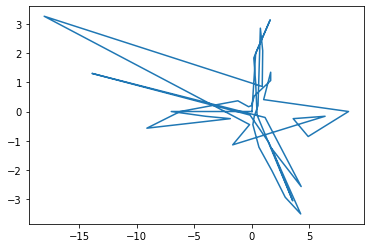

In [ ]:
plt.plot(batch[:, 0], batch[:, 1])
plt.show()

3


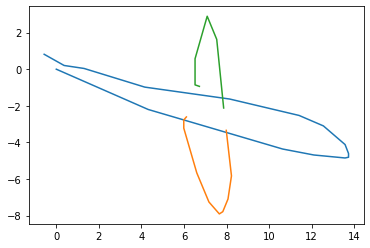

In [ ]:
# James can you fix this pls 
#Yes I can

def sketchplotter(M):
  X=[]
  Y=[]
  #these 'all' variables store every jump in its entirety, the X and Y omit those jumps which are the pen being lifted.
  XALL=[]
  YALL=[]
  strokenumber=0
  for i in range(len(M)): #Originally taking tensor data with size(), had to change to len since it is a numpy tuple
    if i == 0:
      X.append(M[i,0])
      Y.append(M[i,1])
      XALL.append(M[i,0])
      YALL.append(M[i,1])
    elif M[i,3].item()==1: #The slot for the lift up state changed from 2-> 3 when we reformatted the data
      X.append(M[i,0]+XALL[i-1])
      Y.append(M[i,1]+YALL[i-1])
      XALL.append(M[i,0]+XALL[i-1])
      YALL.append(M[i,1]+YALL[i-1])
      strokenumber+=1
      plt.plot(X,Y)
      X=[]
      Y=[]
    else:
      X.append(M[i,0]+XALL[i-1])
      Y.append(M[i,1]+YALL[i-1])
      XALL.append(M[i,0]+XALL[i-1])
      YALL.append(M[i,1]+YALL[i-1])
  plt.plot(X,Y)
  print(strokenumber)
  #print(X)
  #print(Y)

sketchplotter(batch)
plt.show()